<a href="https://colab.research.google.com/github/Snafkin547/Quantum-ML-classification/blob/main/Wine_Classiciation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Package and Data Ingestion

In [2]:
from google.colab import drive
import os
import pandas as pd

#Google Drive mounting to Google Colab
drive.mount('/content/gdrive', force_remount=True)
#Change the working directory
%cd /content/gdrive/MyDrive/QML/Wine-Classification
#Check if the directory was properly changed
%pwd

data=pd.read_csv('wine.csv')

Mounted at /content/gdrive
/content/gdrive/MyDrive/QML/Wine-Classification


In [3]:
x=data.iloc[:,0:len(data.columns)-1]
y=data.iloc[:,-1]

### Train Test split

In [4]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test=train_test_split(x, y, test_size=0.2, random_state=42)
print("Training data has {} features and {} rows".format(x_train.shape[1], x_train.shape[0]))
print("Test data has {} features and {} rows".format(x_test.shape[1], x_test.shape[0]))

Training data has 11 features and 1279 rows
Test data has 11 features and 320 rows


In [5]:
x_train.to_pickle('./x_train.npy')
x_test.to_pickle('./x_test.npy')
y_train.to_pickle('./y_train.npy')
y_test.to_pickle('./y_test.npy')

In [6]:
x_train= pd.read_pickle('./x_train.npy')
x_test= pd.read_pickle('./x_test.npy')
y_train= pd.read_pickle('./y_train.npy')
y_test= pd.read_pickle('./y_test.npy')

# Train the model and Predict

In [7]:
from sklearn.ensemble import RandomForestClassifier as rfm
from sklearn.metrics import accuracy_score

clf=rfm(max_depth=2, random_state=0)
clf.fit(x_train,y_train)
y_hat=clf.predict(x_test)
print("Model accuracy is {}%".format(clf.score(x_test, y_test)*100))
benchmark=clf.score(x_test, y_test)*100

Model accuracy is 72.5%


# Identify The biggest contributing Features

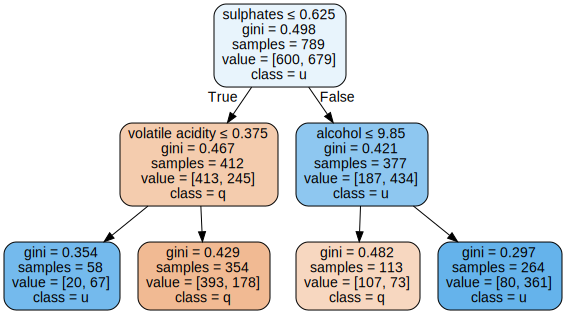

In [8]:
import sklearn
import graphviz 
from sklearn.tree import export_graphviz
dot_data = sklearn.tree.export_graphviz(clf.estimators_[0], out_file=None, 
                     feature_names=x.columns,  
                      class_names=data.columns[-1], 
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

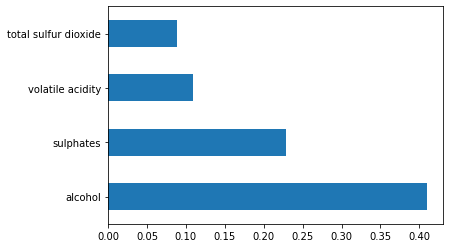

In [9]:
import numpy as np
import pandas as pd
feat_importances = pd.Series(clf.feature_importances_, index=x.columns)
feat_importances.nlargest(4).plot(kind='barh')

# Store 2, 3, and 4 biggest Contributors

In [10]:
two_var=feat_importances.nlargest(4).index[0:2]
three_var=feat_importances.nlargest(4).index[0:3]
four_var=feat_importances.nlargest(4).index[0:4]

# Preparation for Quantum Circuit

In [ ]:
!pip install qiskit
!pip install pylatexenc ipywidgets qutip

In [12]:
train=pd.concat([x_train, y_train], axis=1)
train['int_quality']=list(map(lambda item: 1 if item=='good' else 0, train['quality']))
test=pd.concat([x_test, y_test], axis=1)
test['int_quality']=list(map(lambda item: 1 if item=='good' else 0, test['quality']))
test.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,int_quality
803,7.7,0.56,0.08,2.50,0.114,14.0,46.0,0.9971,3.24,0.66,9.6,good,1
124,7.8,0.50,0.17,1.60,0.082,21.0,102.0,0.9960,3.39,0.48,9.5,bad,0
350,10.7,0.67,0.22,2.70,0.107,17.0,34.0,1.0004,3.28,0.98,9.9,good,1
682,8.5,0.46,0.31,2.25,0.078,32.0,58.0,0.9980,3.33,0.54,9.8,bad,0
1326,6.7,0.46,0.24,1.70,0.077,18.0,34.0,0.9948,3.39,0.60,10.6,good,1


In [13]:
var_name=['al_hi', 'sul_hi','vol_ac_hi', 'sul_dio_hi']
for obj, name in zip(four_var, var_name):
  train[name]=list(map(lambda x: 1 if x>train[obj].mean() else 0, train[obj]))
train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,int_quality,al_hi,sul_hi,vol_ac_hi,sul_dio_hi
493,8.7,0.690,0.31,3.0,0.086,23.0,81.0,1.00020,3.48,0.74,11.6,good,1,1,1,1,1
354,6.1,0.210,0.40,1.4,0.066,40.5,165.0,0.99120,3.25,0.59,11.9,good,1,1,0,0,1
342,10.9,0.390,0.47,1.8,0.118,6.0,14.0,0.99820,3.30,0.75,9.8,good,1,0,1,0,0
834,8.8,0.685,0.26,1.6,0.088,16.0,23.0,0.99694,3.32,0.47,9.4,bad,0,0,0,1,0
705,8.4,1.035,0.15,6.0,0.073,11.0,54.0,0.99900,3.37,0.49,9.9,bad,0,0,0,1,1


In [14]:
var_name=['al_hi', 'sul_hi','vol_ac_hi', 'sul_dio_hi']
for obj, name in zip(four_var, var_name):
  test[name]=list(map(lambda x: 1 if x>test[obj].mean() else 0, test[obj]))
test.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,int_quality,al_hi,sul_hi,vol_ac_hi,sul_dio_hi
803,7.7,0.56,0.08,2.50,0.114,14.0,46.0,0.9971,3.24,0.66,9.6,good,1,0,1,1,1
124,7.8,0.50,0.17,1.60,0.082,21.0,102.0,0.9960,3.39,0.48,9.5,bad,0,0,0,0,1
350,10.7,0.67,0.22,2.70,0.107,17.0,34.0,1.0004,3.28,0.98,9.9,good,1,0,1,1,0
682,8.5,0.46,0.31,2.25,0.078,32.0,58.0,0.9980,3.33,0.54,9.8,bad,0,0,0,0,1
1326,6.7,0.46,0.24,1.70,0.077,18.0,34.0,0.9948,3.39,0.60,10.6,good,1,1,0,0,0


In [15]:
#Probability of being high alcohol rate 
cnt_al_hi=len(train[train['al_hi']==1])
cnt_al_lo=len(train[train['al_hi']!=1])
prob_al_hi=cnt_al_hi/len(train)

#Probability of being high sulphate rate 
cnt_sul_hi=len(train[train['sul_hi']==1])
cnt_sul_lo=len(train[train['sul_hi']!=1])
prob_sul_hi=cnt_sul_hi/len(train)

#Probability of being good quality wine
cnt_qual_hi=len(train[train['quality']=="good"])
cnt_qual_lo=len(train[train['quality']!="good"])
prob_good=cnt_qual_hi/len(train)
prob_sul_hi

0.3737294761532447

In [16]:
#High Qual, High Al, High sul
HA=train[train['al_hi']==1]
HA_HS=HA[HA['sul_hi']==1]
HQ_HA_HS=HA_HS[HA_HS['quality']=="good"]
p_HQ_HA_HS=len(HQ_HA_HS)/len(HA_HS)
LQ_HA_HS=HA_HS[HA_HS['quality']=="bad"]
p_LQ_HA_HS=len(LQ_HA_HS)/len(HA_HS)

#High Qual, High Al, Low sul
HA=train[train['al_hi']==1]
HA_LS=HA[HA['sul_hi']!=1]
HQ_HA_LS=HA_LS[HA_LS['quality']=="good"]
p_HQ_HA_LS=len(HQ_HA_LS)/len(HA_LS)
LQ_HA_LS=HA_LS[HA_LS['quality']=="bad"]
p_LQ_HA_LS=len(LQ_HA_LS)/len(HA_LS)


#High Qual, Low Al, High sul
LA=train[train['al_hi']!=1]
LA_HS=LA[LA['sul_hi']==1]
HQ_LA_HS=LA_HS[LA_HS['quality']=="good"]
p_HQ_LA_HS=len(HQ_LA_HS)/len(LA_HS)
LQ_LA_HS=LA_HS[LA_HS['quality']=="bad"]
p_LQ_LA_HS=len(LQ_LA_HS)/len(LA_HS)

#High Qual, Low Al, Low sul
LA=train[train['al_hi']!=1]
LA_LS=LA[LA['sul_hi']!=1]
HQ_LA_LS=LA_LS[LA_LS['quality']=="good"]
p_HQ_LA_LS=len(HQ_LA_LS)/len(LA_LS)
LQ_LA_LS=LA_LS[LA_LS['quality']=="bad"]
p_LQ_LA_LS=len(LQ_LA_LS)/len(LA_LS)

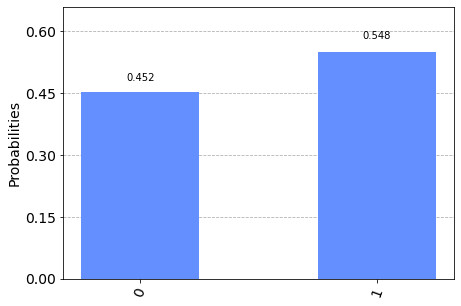

In [17]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute, result
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from math import pi, sqrt, sin, cos, asin

QPOS_AL=0
QPOS_SUL=1
QPOS_NORM=2
QUBITS=3

def prob_to_angle(prob):
  return 2*asin(sqrt(prob))

def ccry(qc, theta, control1, control2, controlled):
  qc.cry(theta/2, control2, controlled)
  qc.cx(control1, control2)
  qc.cry(-theta/2, control2, controlled)
  qc.cx(control1, control2)
  qc.cry(theta/2, control1, controlled)

qr=QuantumRegister(QUBITS)
cr=ClassicalRegister(1)
qc=QuantumCircuit(qr,cr)

# Apply prob of high alcohol 
qc.ry(prob_to_angle(prob_al_hi),QPOS_AL)

# Apply prob of high alcohol 
qc.ry(prob_to_angle(prob_sul_hi),QPOS_SUL)

# |00> for cond prob of High Qual, Low Al & Low Sul
qc.x(0)
qc.x(1)
ccry(qc, prob_to_angle(p_HQ_LA_LS), QPOS_AL, QPOS_SUL, QPOS_NORM)
qc.x(1)
qc.x(0)

# |01> for cond prob of High Qual, Low Al & High Sul
qc.x(0)
ccry(qc, prob_to_angle(p_HQ_LA_HS), QPOS_AL, QPOS_SUL, QPOS_NORM)
qc.x(0)

# |10> for cond prob of High Qual, High Al & Low Sul
qc.x(1)
ccry(qc, prob_to_angle(p_HQ_HA_LS), QPOS_AL, QPOS_SUL, QPOS_NORM)
qc.x(1)

# |11> for cond prob of High Qual, High Al & High Sul

ccry(qc, prob_to_angle(p_HQ_HA_HS), QPOS_AL, QPOS_SUL, QPOS_NORM)

qc.measure(qr[QPOS_NORM], cr[0])
results=execute(qc,Aer.get_backend('qasm_simulator'), shots=1000).result().get_counts()
plot_histogram(results)


In [18]:
def as_pqc(cnt_quantum, with_qc, cnt_classical=1, shots=1, hist=False, measure=False):
# Prepare the circuit with qubits and a classical bit to hold the measurement
  qr = QuantumRegister(cnt_quantum)
  cr = ClassicalRegister(cnt_classical)
  qc = QuantumCircuit(qr, cr) if measure else QuantumCircuit(qr)

  with_qc(qc, qr=qr, cr=cr)

  results = execute(qc,
  Aer.get_backend('statevector_simulator') if measure is False else Aer.get_backend('qasm_simulator'),
  shots=shots).result().get_counts()
  return plot_histogram(results, figsize=(12,4)) if hist else results

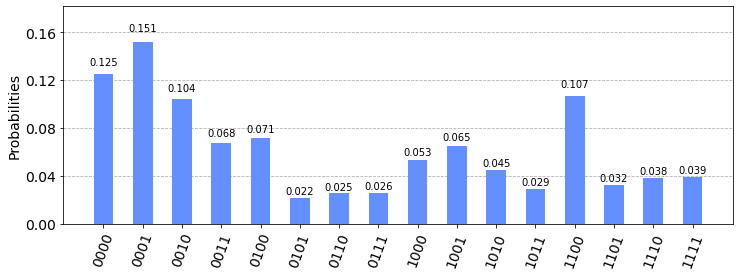

In [19]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute, result
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from math import pi, sqrt, sin, cos, asin

QPOS_AL=0
QPOS_SUL=1
QPOS_NORM=2
QPOS_QUAL=3
QUBITS=4

def prob_to_angle(prob):
  return 2*asin(sqrt(prob))

def ccry(qc, theta, control1, control2, controlled):
  qc.cry(theta/2, control2, controlled)
  qc.cx(control1, control2)
  qc.cry(-theta/2, control2, controlled)
  qc.cx(control1, control2)
  qc.cry(theta/2, control1, controlled)

def apply_al_sul(qc):
  # Apply prob of high alcohol 
  qc.ry(prob_to_angle(prob_al_hi),QPOS_AL)

  # Apply prob of high sulphide 
  qc.ry(prob_to_angle(prob_sul_hi),QPOS_SUL)


def apply_norm(qc, norm_params):
  # |100> for cond prob of Low Al & Low Sul, High Qual
  qc.x(QPOS_AL)
  qc.x(QPOS_SUL)
  ccry(qc, prob_to_angle(norm_params['p_llh']), QPOS_AL, QPOS_SUL, QPOS_NORM)
  qc.x(QPOS_SUL)
  qc.x(QPOS_AL)

  # |110> for cond prob of Low Al & High Sul, High Qual
  qc.x(QPOS_AL)
  ccry(qc, prob_to_angle(norm_params['p_lhh']), QPOS_AL, QPOS_SUL, QPOS_NORM)
  qc.x(QPOS_AL)

  # |101> for cond prob of High Al & Low Sul, High Qual
  qc.x(QPOS_SUL)
  ccry(qc, prob_to_angle(norm_params['p_hlh']), QPOS_AL, QPOS_SUL, QPOS_NORM)
  qc.x(QPOS_SUL)

  # |111> for cond prob of High Al & High Sul, High Qual
  ccry(qc, prob_to_angle(norm_params['p_hhh']), QPOS_AL, QPOS_SUL, QPOS_NORM)


def apply_qual(qc, qual_params):
  qc.x(QPOS_NORM)
  qc.cry(prob_to_angle(qual_params['p_qual_u']), QPOS_NORM, QPOS_QUAL)
  qc.x(QPOS_NORM)

  qc.cry(prob_to_angle(qual_params['p_qual_f']), QPOS_NORM, QPOS_QUAL)

def qbn_wine(norm_params, qual_params, hist=True, measure=False, shots=1):
  def circuit(qc, qr=None, cr=None):
    apply_al_sul(qc)
    apply_norm(qc, norm_params)
    apply_qual(qc, qual_params)
    qc.draw('mpl')
  return as_pqc(QUBITS, circuit, hist=hist, measure=measure, shots=shots)

norm_params={
    'p_llh': 0.5,
    'p_lhh': 0.3,
    'p_hlh': 0.2,
    'p_hhh': 0.4
}

qual_params={
    'p_qual_f':0.6,
    'p_qual_u':0.3
}

qbn_wine(norm_params, qual_params, hist=True, measure=False, shots=1)

In [20]:
def calculate_norm_params(train):
  #High Qual, High Al, High sul
  HA=train[train['al_hi']==1]
  HA_HS=HA[HA['sul_hi']==1]

  #High Qual, High Al, Low sul
  HA=train[train['al_hi']==1]
  HA_LS=HA[HA['sul_hi']!=1]

  #High Qual, Low Al, High sul
  LA=train[train['al_hi']!=1]
  LA_HS=LA[LA['sul_hi']==1]

  #High Qual, Low Al, Low sul
  LA=train[train['al_hi']!=1]
  LA_LS=LA[LA['sul_hi']!=1]
  
  norm_params={
      'p_hhh':HA_HS.Norm.sum()/len(HA_HS),
      'p_hlh':HA_LS.Norm.sum()/len(HA_LS),
      'p_lhh':LA_HS.Norm.sum()/len(LA_HS),
      'p_llh':LA_LS.Norm.sum()/len(LA_LS)
  }
  return norm_params

In [21]:
def calculate_qual_params(data):
  hi_quality=data[data['quality']=='good']
  
  def weight_qual(norm):
    return lambda x: x if norm else 1-x

  def calc_prob(norm):
    return sum(list(map(weight_qual(norm), list(hi_quality['Norm']))))/sum(list(map(weight_qual(norm), list(data['Norm']))))

  qual_params={
    'p_qual_f':calc_prob(True),
    'p_qual_u':calc_prob(False)
  }

  return qual_params

In [22]:
def prepare_data(data, params):
  data['Norm']=list(map(
      lambda item: params['p_norm_{}{}{}'.format(
          'h' if item[0]==1 else 'l',
          'h' if item[1]==1 else 'l',
          'h' if item[2]=='good' else 'l'
      )],
      list(zip(data['al_hi'], data['sul_hi'], data['quality']))
      ))
  return data 

arbitrary_params={
    'p_norm_hhh': p_HQ_HA_HS,
    'p_norm_hlh': p_HQ_HA_LS,
    'p_norm_lhh': p_HQ_LA_HS,
    'p_norm_llh': p_HQ_LA_LS,
    'p_norm_hhl': p_LQ_HA_HS,
    'p_norm_hll': p_LQ_HA_LS,
    'p_norm_lhl': p_LQ_LA_HS,
    'p_norm_lll': p_LQ_LA_LS
    }

prepared_data=prepare_data(train,arbitrary_params)
prepared_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,int_quality,al_hi,sul_hi,vol_ac_hi,sul_dio_hi,Norm
493,8.7,0.690,0.31,3.0,0.086,23.0,81.0,1.00020,3.48,0.74,11.6,good,1,1,1,1,1,0.838710
354,6.1,0.210,0.40,1.4,0.066,40.5,165.0,0.99120,3.25,0.59,11.9,good,1,1,0,0,1,0.666667
342,10.9,0.390,0.47,1.8,0.118,6.0,14.0,0.99820,3.30,0.75,9.8,good,1,0,1,0,0,0.537688
834,8.8,0.685,0.26,1.6,0.088,16.0,23.0,0.99694,3.32,0.47,9.4,bad,0,0,0,1,0,0.710227
705,8.4,1.035,0.15,6.0,0.073,11.0,54.0,0.99900,3.37,0.49,9.9,bad,0,0,0,1,1,0.710227


In [23]:
results=qbn_wine(calculate_norm_params(prepared_data), calculate_qual_params(train), hist=False, measure=False, shots=1)

In [24]:
def filter_states(states, position, value):
  return list(filter(lambda item: item[0][QUBITS-1-position]==str(value), states))

def sum_states(states):
  return sum(map(lambda item: item[1], states))

In [25]:
filter_states(results.items(), QPOS_AL, 1)

[('0001', 0.060064517272767),
 ('0011', 0.021819553036571),
 ('0101', 0.067924680713379),
 ('0111', 0.053221868989647),
 ('1001', 0.060064517272766),
 ('1011', 0.021819553036571),
 ('1101', 0.082236612468538),
 ('1111', 0.064435874692169)]

In [26]:
sum_states(filter_states(results.items(), QPOS_QUAL, '1'))

0.5278351324555581

In [27]:
from math import log

def log_likelihood_wine(data, results):
  states=results.items()

  def calc_prob(norm_val, hi_al, hi_sul, hi_qual):
    return sum_states(
        filter_states(
          filter_states(
            filter_states(
                filter_states(states, QPOS_AL, hi_al),
                QPOS_SUL, hi_sul),
                QPOS_QUAL, hi_qual),
                QPOS_NORM, norm_val))
  
  probs={
    'p_fhhh': calc_prob('1', '1','1','1'),
    'p_fhlh': calc_prob('1', '1','0','1'),
    'p_flhh': calc_prob('1', '0','1','1'),
    'p_fllh': calc_prob('1', '0','0','1'),
    'p_fhhl': calc_prob('1', '1','1','0'),
    'p_fhll': calc_prob('1', '1','0','0'),
    'p_flhl': calc_prob('1', '0','1','0'),
    'p_flll': calc_prob('1', '0','0','0'),
    'p_uhhh': calc_prob('0', '1','1','1'),
    'p_uhlh': calc_prob('0', '1','0','1'),
    'p_ulhh': calc_prob('0', '0','1','1'),
    'p_ullh': calc_prob('0', '0','0','1'),
    'p_uhhl': calc_prob('0', '1','1','0'),
    'p_uhll': calc_prob('0', '1','0','0'),
    'p_ulhl': calc_prob('0', '0','1','0'),
    'p_ulll': calc_prob('0', '0','0','0')
  }
  return round(sum(map(
      lambda item: log(probs['p_{}{}{}{}'.format(
          'u',
          'h' if item[1]==1 else 'l',
          'h' if item[2]==1 else 'l',
          'h' if item[3]==1 else 'l'
          )] + probs['p_{}{}{}{}'.format(
          'f',
          'h' if item[1]==1 else 'l',
          'h' if item[2]==1 else 'l',
          'h' if item[3]==1 else 'l'
          )]
      ),
      list(zip(data['Norm'], data['al_hi'], data['sul_hi'], data['quality']))
  )),3)

log_likelihood_wine(train, results)


-2681.568

In [28]:
results=qbn_wine(calculate_norm_params(prepared_data), calculate_qual_params(train), hist=False, measure=False, shots=1)

In [29]:
def to_params(results):
  states=results.items()

  def calc_norm(hi_al, hi_sul, hi_qual):
    pop=filter_states(filter_states(filter_states(states, QPOS_AL, hi_al),QPOS_SUL, hi_sul),QPOS_QUAL, hi_qual)
    p_norm=sum(map(lambda item: item[1], filter_states(pop, QPOS_NORM, '1')))
    p_total=sum(map(lambda item: item[1], pop))
    return p_norm/p_total # new norm param based on if norm/al+sal+qual
  
  return{
    'p_norm_hhh': calc_norm('1','1', '1'),
    'p_norm_hlh': calc_norm('1','0', '1'),
    'p_norm_lhh': calc_norm('0','1', '1'),
    'p_norm_llh': calc_norm('0','0', '1'),
    'p_norm_hhl': calc_norm('1','1', '0'),
    'p_norm_hll': calc_norm('1','0', '0'),
    'p_norm_lhl': calc_norm('0','1', '0'),
    'p_norm_lll': calc_norm('0','0', '0')
    }

to_params(results)

{'p_norm_hhh': 0.7470355940360052,
 'p_norm_hhl': 0.7092332148376976,
 'p_norm_hlh': 0.577905548733449,
 'p_norm_hll': 0.5307063547716847,
 'p_norm_lhh': 0.5255779674964096,
 'p_norm_lhl': 0.4778146021956294,
 'p_norm_llh': 0.6102482065249825,
 'p_norm_lll': 0.5639366780222077}

In [30]:
def train_qbn_wine(prepared_data, params, iterations, print=False):
  if iterations>0:

    new_params=train_qbn_wine(prepared_data, params, iterations-1)
    prepared_data=prepare_data(prepared_data, new_params)
    results=qbn_wine(calculate_norm_params(prepared_data),
                     calculate_qual_params(prepared_data), hist=False)
    if print:
      print('The log−likelihood after {} iteration(s) is {}'.format(iterations, log_likelihood_wine(prepared_data, results)))
    return to_params(results)
  
  return params

In [31]:
def pre_process(prepared_data):
  return (prepared_data['al_hi']==1, prepared_data['sul_hi']==1)

In [32]:
def apply_known(qc, al_hi, sul_hi):
  if al_hi:
    qc.x(QPOS_AL)
  if sul_hi:
    qc.x(QPOS_SUL)

In [33]:
def get_trained_qbn(data, params):
  prepared_data=prepare_data(data, params)
  norm_params=calculate_norm_params(data)
  qual_params=calculate_qual_params(data)

  def trained_qbn_wine(d):
    (al_hi, sul_hi) = d

    def circuit(qc, qr, cr):
      apply_known(qc, al_hi, sul_hi)
      apply_norm(qc, norm_params)
      apply_qual(qc, qual_params)
      qc.measure(qr[QPOS_QUAL], cr[0])
    
    return as_pqc(QUBITS, circuit, hist=False, measure=True, shots=100)
  
  return trained_qbn_wine

In [34]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
def specificity(matrix):
    return matrix[0][0]/(matrix[0][0]+matrix[0][1]) if (matrix[0][0]+matrix[0][1] > 0) else 0

def npv(matrix):
    return matrix[0][0]/(matrix[0][0]+matrix[1][0]) if (matrix[0][0]+matrix[1][0] > 0) else 0

def accuracy(matrix):
   return (matrix[0][0]+matrix[1][1])/(matrix[0][0]+matrix[0][1]+matrix[1][0]+matrix[1][1]) if (matrix[0][0]+matrix[0][1]+matrix[1][0]+matrix[1][1] > 0) else 0

def classifier_report(name, run, classify, input, labels):
    cr_predictions = run(classify, input)
    cr_cm = confusion_matrix(labels, cr_predictions)
    cr_precision = precision_score(labels, cr_predictions)
    cr_recall = recall_score(labels, cr_predictions)
    cr_specificity = specificity(cr_cm)
    cr_npv = npv(cr_cm)
    cr_level = 0.25*(cr_precision + cr_recall + cr_specificity + cr_npv)
    accuracy_s=accuracy(cr_cm)

    print('The precision score of the {} classifier is {:.2f}'
        .format(name, cr_precision))
    print('The recall score of the {} classifier is {:.2f}'
        .format(name, cr_recall))
    print('The specificity score of the {} classifier is {:.2f}'
        .format(name, cr_specificity))
    print('The npv score of the {} classifier is {:.2f}'
        .format(name, cr_npv))
    print('The information level is: {:.2f}'
        .format(cr_level))
    print('The accuracy of the model is: {:.2f}'
        .format(accuracy_s))
    print('')

    return accuracy_s

def run(f_classify, data):
    return [f_classify(data.iloc[i]) for i in range(0,len(data))]

def post_process(counts):
  p_good=counts['1'] if '1' in counts.keys() else 0
  p_bad=counts['0'] if '0' in counts.keys() else 0
  return 1 if p_good>p_bad else 0

# Predict

---Test data 1 Iterations---
The precision score of the QBN classifier is 0.56
The recall score of the QBN classifier is 0.69
The specificity score of the QBN classifier is 0.32
The npv score of the QBN classifier is 0.45
The information level is: 0.51
The accuracy of the model is: 0.53

---Training data 1 Iteration---
The precision score of the QBN classifier is 0.54
The recall score of the QBN classifier is 0.70
The specificity score of the QBN classifier is 0.33
The npv score of the QBN classifier is 0.50
The information level is: 0.52
The accuracy of the model is: 0.53

---Test data 10 Iterations---
The precision score of the QBN classifier is 0.73
The recall score of the QBN classifier is 0.74
The specificity score of the QBN classifier is 0.65
The npv score of the QBN classifier is 0.66
The information level is: 0.70
The accuracy of the model is: 0.70

---Training data 10 Iteration---
The precision score of the QBN classifier is 0.71
The recall score of the QBN classifier is 0.73

([<matplotlib.axis.XTick at 0x7fa359161d90>,
 <a list of 5 Text major ticklabel objects>)

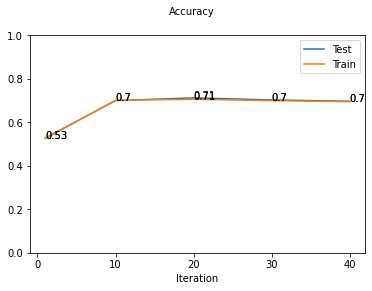

In [39]:
def predict(train, test, arbitrary_params, iter):
    trained_params=train_qbn_wine(train, arbitrary_params,iter)

    trained_qbn=get_trained_qbn(train, trained_params)

    return classifier_report("QBN",
                    run,
                    lambda d : post_process(trained_qbn(pre_process(d))),
                    test,
                    test['int_quality']
                    )

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(x[i],y[i],round(y[i],2))
        
iterations=[1,10,20,30,40]
results_test=[]
results_train=[]

arbitrary_params={
    'p_norm_hhh': p_HQ_HA_HS,
    'p_norm_hlh': p_HQ_HA_LS,
    'p_norm_lhh': p_HQ_LA_HS,
    'p_norm_llh': p_HQ_LA_LS,
    'p_norm_hhl': p_LQ_HA_HS,
    'p_norm_hll': p_LQ_HA_LS,
    'p_norm_lhl': p_LQ_LA_HS,
    'p_norm_lll': p_LQ_LA_LS
    }

for i in iterations:
   print("---Test data {} Iterations---".format(i))
   results_test.append(predict(train, test, arbitrary_params, i))
   print("---Training data {} Iteration---".format(i))
   results_train.append(predict(train, train, arbitrary_params, i))

plt.plot(iterations, results_test, label="Test")
addlabels(iterations, results_test)
plt.plot(iterations, results_train, label="Train")
addlabels(iterations, results_train)
plt.xlabel("Iteration")
plt.ylim(0,1)
plt.legend()
plt.suptitle('Accuracy',fontsize=10)
plt.xticks(np.arange(0, 50,10))